## QZ法の実装

講義ノートの記法を踏襲し, $x^1_t$ を先決変数, $x^2_t$ を非先決変数として, システム変数の分解 $x_t = (x^1_t, x^2_t)$ ができているとする. 

システム方程式

\begin{align}
  Ex_{t+1} = Ax_t + Bu_t
\end{align}

の解から爆発的に発散するものを取り除くことで次の方程式を得る.

\begin{align}
  x^1_{t+1} &= \Omega_x x_t^1 + \Omega_u u_t + \Omega_y y^u_{t+1}\\
  x^2_t &= \Psi_x x_t^1 + \Psi_y y^u_t
\end{align}

 これが Blanchard-Kahn (1980) にはじまる合理的期待モデルの分析の味噌である. 

ただし, $y^u_t = y^u(u_t, u_{t+1}, \dots)$ は未来のショックに対する期待・予見を反映して決まる. 

以下では Python を使って手を動かしながら, 理論の応用方法を習得してほしい. 

## 準備

サードパーティライブラリの Numpy と Scipy をインポートしておく. 行列計算のための scipy サブパッケージ scipy.linalg を利用するので, こちらもインポートしておく. 

<code>
import _[LIBRARY]_ as _[ALIAS]_
</code>

という構文は頻繁に使うので, 手になじませておくべきだろう. 

In [1]:
import sys # Python のバージョン取得のため

import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline 
# Jupyter Notebook で図をノート内に表示

筆者と読者の環境の違いを把握できるようにバージョンを確認しておこう. 

In [2]:
print(sys.version)

3.5.1 |Anaconda 4.0.0 (x86_64)| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]


In [3]:
print(np.__version__)

1.10.4


In [4]:
print(sp.__version__)

0.17.0


## QZ 分解

数値計算のための基本となる道具は, ペンシル $(E,A)$ のQZ分解である. 同じサイズをもつ任意の正方行列 $(E, A)$ に対してユニタリ行列 $Q$, $Z$ が存在して, 

\begin{align}
Q^* E Z = S, \qquad Q^* A Z = T
\end{align}

が上三角行列になる. 特に, $(E,A)$ がレギュラー ($\exists s\in\mathbb{C}; \det (sE-A) \neq 0$) であれば, 対角成分 $(s_{ii}, t_{ii})$ が一般固有値に関する情報をもっている. この条件がなければ均衡経路の一意性はまったく期待できない. やや技術的ではあるが, レギュラー性の仮定は以下で $T_{uu}$ が可逆であることをいうのに使っている. 各自確認しほしい. 


### 例1) QZ分解の例

宿題3 [16EDH3], 問題2の行列ペア

\begin{align}
E = \begin{bmatrix}
  0 & -1 & 3\\
  0 & 0  & -1\\
  0 & 0  & -1
\end{bmatrix}, 
\qquad
A = \begin{bmatrix}
  2 & 2 & -2\\
  -1 & 0  & 0\\
  -1 & 0  & -1
\end{bmatrix}
\end{align}

に対するQZ分解を計算してみよう.  

まずは Numpy 配列の生成から. 

In [5]:
E = np.array([
        [0, -1,  3],
        [0,  0, -1],
        [0,  0, -1]
    ])

A = np.array([
        [ 2,  2, -2],
        [-1,  0,  0],
        [-1,  0,  1]
    ])

In [6]:
E

array([[ 0, -1,  3],
       [ 0,  0, -1],
       [ 0,  0, -1]])

In [7]:
A

array([[ 2,  2, -2],
       [-1,  0,  0],
       [-1,  0,  1]])

Python で QZ分解を実行するには, scipy.linalg の `qz` あるいは `ordqz` を使えばよい. 一般化固有値の並べ替えが必要なので, `ordqz` を使うのがよいだろう. まずはドキュメントを見てみよう. ドキュメントやエラーメッセージの解読はプログラミングの大切な一部なので, 決して避けて通ろうとしないように.  

`ordqz` には必要な情報のすべては書かれていなかった (例えば `A` と `AA` の関係がこれだけでは分からない). See also の欄にある `qz` のドキュメントも見ておこう. 

これらの内容を合わせると, `ordqz` は

    AA, BB, alpha, beta, Q, Z = ordqz(A, B)
    
の形式で呼び出し, AA が A を上三角化したもの, BB が B を上三角化したものであることが分かる. 分解は `A=Q*AA*Z'`, `B=Q*BB*Z'` が成り立つように行列`Q`, `Z` が作られている. これは我々の記法とほとんど同じであるが, `ordqz` は実QZ分解を行なっているという点で異なっている. その事実は, Parameters の欄の

    output : str {'real','complex'}, optional
        Construct the real or complex QZ decomposition for real matrices.
        Default is 'real'.
        
というオプション引数の説明から分かる. デフォルトは `'real'` であり，あえて複素QZ分解（普通のQZ分解）を出力するには, `ordqz(A, B, output='complex')` の形式で呼び出す必要がある. しかし, 実QZ分解でもまったく問題がないのでこの違いは気にしないでおこう. Klein (2000) は実QZ分解を使った計算の方が高速であると述べているので, わざわざ複素QZ分解を使う理由はない. 

さらに，`ordqz` のドキュメントには

    On exit, ``(ALPHAR(j) + ALPHAI(j)*i)/BETA(j), j=1,...,N``, will be the
    generalized eigenvalues.
    
と書かれているので, このQZ分解は

\begin{align}
    Bx_{t+1} = Ax_t
\end{align}

という線形方程式に対応しているものと分かる. したがって, われわれの記号の下では, 次のように呼び出せばよい. 

In [8]:
T, S, tii, sii, Q, Z = la.ordqz(A, E)

/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/scipy/linalg/_decomp_qz.py:23: RuntimeWarning: divide by zero encountered in true_divide
  sfunction = lambda x, y: (np.real(x/y) < 0.0)
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/scipy/linalg/_decomp_qz.py:23: RuntimeWarning: invalid value encountered in true_divide
  sfunction = lambda x, y: (np.real(x/y) < 0.0)


divide by zero (ゼロ割) の警告は非正則な E を入れるとでてしまうが, これは安全に無視できる. 煩わしい場合は消すこともできるが, さしあたって問題にならないのでそのままにしておこう. 

In [9]:
T

array([[-2.        ,  2.        , -2.        ],
       [ 0.        ,  1.41421356, -0.70710678],
       [ 0.        ,  0.        , -0.70710678]])

In [10]:
S

array([[ 1.        ,  0.        ,  3.        ],
       [ 0.        ,  0.        ,  1.41421356],
       [ 0.        ,  0.        ,  0.        ]])

In [11]:
tii

array([-2.00000000+0.j,  1.41421356+0.j, -0.70710678+0.j])

In [12]:
sii

array([ 1.,  0.,  0.])

$T = Q^* A Z$, $S = Q^* E Z$ が成り立つことを確認しておこう. 数値計算では「完全に一致すること」を期待してはいけない. 十分近くにあるかどうかを確かめる. これは numpy.allclose() で確認できる. 

ちなみに, Python では `Q` の共役転置行列は `Q.conj().T` などと書く. 

In [13]:
np.allclose(T, Q.conj().T.dot(A).dot(Z))

True

In [14]:
np.allclose(S, Q.conj().T.dot(E).dot(Z))

True

これで間違いなく望む上三角化できていることが分かった. 


### 例2) 固有値のソーティング

Klein の方法では左上ブロックに一般化固有値の絶対値が$1$以下のもの, 右下ブロックには絶対値が$1$より大きいものが来るようにしなければならないことを思い出そう. 一般化固有値は `tii / sii` で取り出せるのでこれを見ればよい. 

In [15]:
tii / sii

/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([ -2. +0.j,  inf+nanj, -inf+nanj])

したがって `-2` という有限固有値と, 代数的重複度$2$の無限大固有値が存在することが分かる. すべてが不安定固有値なので, 安定-不安定の分解は自明なものではあるが, うまく行っている. 

しかし, これはいつも成り立つ訳ではない. 次の例を見れば分かるように, `ordqz` のデフォルトでは固有値の並びは制御されていない. **以下では次の行列ペアを考えよう**. 

In [16]:
E = np.array([[-0.04384211,  0.06263158,  0.04384211, -1.05263158],
              [ 0.        ,  0.        ,  0.        ,  0.        ],
              [ 1.        ,  0.        ,  0.        ,  0.        ],
              [ 0.        ,  1.        ,  0.        ,  0.        ]])

A = np.array([[ 0.        ,  0.        ,  0.        , -1.05263158],
              [ 0.3       ,  1.        , -0.72012357, -1.        ],
              [ 1.05263158,  0.20877193,  0.14614035, -0.19877193],
              [ 0.        ,  0.95      ,  0.        ,  0.        ]])
T, S, tii, sii, Q, Z = la.ordqz(A, E)
tii / sii

/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/scipy/linalg/_decomp_qz.py:23: RuntimeWarning: divide by zero encountered in true_divide
  sfunction = lambda x, y: (np.real(x/y) < 0.0)
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/scipy/linalg/_decomp_qz.py:23: RuntimeWarning: invalid value encountered in true_divide
  sfunction = lambda x, y: (np.real(x/y) < 0.0)
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


array([ 1.16284231 +0.j,  0.90522297 +0.j,         inf+nanj,
        0.95000000 +0.j])

並び替えは上手くいっていないようだが, どのようにすれば Klein (2000) に準拠した並び替えができるだろうか？

再びドキュメントに戻って Parameters の項目を見てみると, `ordqz` は `sort` パラメータを取れることが分かる.

<pre style='font-size:80%'>
    Parameters
    ----------
    ...

    sort : {callable, 'lhp', 'rhp', 'iuc', 'ouc'}, optional
        Specifies whether the upper eigenvalues should be sorted.  A callable
        may be passed that, given a eigenvalue, returns a boolean denoting
        whether the eigenvalue should be sorted to the top-left (True). For
        real matrix pairs, the sort function takes three real arguments
        (alphar, alphai, beta). The eigenvalue
        ``x = (alphar + alphai*1j)/beta``.  For complex matrix pairs or
        output='complex', the sort function takes two complex arguments
        (alpha, beta). The eigenvalue ``x = (alpha/beta)``.
        Alternatively, string parameters may be used:

            - 'lhp'   Left-hand plane (x.real < 0.0)
            - 'rhp'   Right-hand plane (x.real > 0.0)
            - 'iuc'   Inside the unit circle (x*x.conjugate() < 1.0)
            - 'ouc'   Outside the unit circle (x*x.conjugate() > 1.0)
</pre>

`callable` というのは荒く言えば関数のことで, `callable` をパラメータに取れるということは, 固有値の並び順を決めるソート関数を自由に定義できることを意味している. 

われわれの目的では, `'iuc'` という定義済み順序を使えば十分そうに見えるが, 絶対値が$1$の固有値があるときにはうまくいかないのでソート関数`iouc`を定義しておこう.

#### 練習問題

`np.ordqz(A, E, sort='iuc')` の形式で QZ 分解を行うとKleinが指定した固有値の並びと合わなくなる場合がある. 例を1つ探しなさい


#### ソート関数 `iouc`

In [17]:
def iouc(a, b):
    """inside or on unit circle"""
    return a*a.conjugate() / (b*b) <= 1.0

実際に確かめてみよう. 

In [18]:
T, S, tii, sii, Q, Z = la.ordqz(A, E, sort=iouc)
eig = tii / sii
eig

/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/kenjisato/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


array([  9.05222973e-01+0.j,   9.50000000e-01+0.j,   1.16284231e+00+0.j,
        -8.38612679e+33+0.j])

これで望ましい結果を得ることができた. 

なお, $1$ より小さい絶対値をもつ固有値の数 $n_s$ は次のようにして取得できる. 

In [19]:
ns = sum(eig*eig.conjugate() <= 1)
ns

2

## 行列ブロックの表現

関連する行列のブロック表現を確認しておこう. 

\begin{align}
Z=
    \begin{bmatrix}
        Z_{1s} & Z_{1u}\\
        Z_{2s} & Z_{2u}
    \end{bmatrix}
    \qquad 
    Q^* B = C = 
    \begin{bmatrix}
        C_s \\
        C_u
    \end{bmatrix}
\end{align}

\begin{align}
T=
    \begin{bmatrix}
        T_{ss} & T_{su}\\
        0 & T_{uu}
    \end{bmatrix}
\qquad
S=
    \begin{bmatrix}
        S_{ss} & S_{su}\\
        0 & S_{uu}
    \end{bmatrix}
\end{align}

引き続き先ほどの例2で使った行列ペアを考えよう. $B$ および $C$ 以外はすべて明らかになっている. 例えば, 次のように設定しよう.

In [20]:
B = np.array([[ 0.],
              [ 0.],
              [ 0.],
              [ 1.]])

In [21]:
E

array([[-0.04384211,  0.06263158,  0.04384211, -1.05263158],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ]])

In [22]:
A

array([[ 0.        ,  0.        ,  0.        , -1.05263158],
       [ 0.3       ,  1.        , -0.72012357, -1.        ],
       [ 1.05263158,  0.20877193,  0.14614035, -0.19877193],
       [ 0.        ,  0.95      ,  0.        ,  0.        ]])

In [23]:
Q

array([[  5.16348163e-01,  -3.32227570e-01,   7.89309455e-01,
          2.13689563e-17],
       [ -7.18084910e-18,   7.60484364e-18,  -1.11023051e-17,
          1.00000000e+00],
       [ -8.56378756e-01,  -2.00314516e-01,   4.75909152e-01,
          1.36953913e-18],
       [ -0.00000000e+00,   9.21682666e-01,   3.87944666e-01,
         -2.70217253e-18]])

In [24]:
Z

array([[-0.85720237, -0.05533784,  0.47711661, -0.18574595],
       [-0.        ,  0.77048231, -0.15167857, -0.61915315],
       [ 0.26010265,  0.4957814 ,  0.69839117,  0.44586678],
       [-0.44446676,  0.39685708, -0.51147153,  0.61915315]])

In [25]:
T

array([[ 0.90609357, -0.29806316, -0.29945132, -0.00879298],
       [ 0.        ,  0.79415423, -0.44674819, -0.24894418],
       [-0.        , -0.        ,  0.68995773, -0.92474003],
       [-0.        , -0.        , -0.        , -1.61510927]])

In [26]:
S

array([[  1.00096174e+00,  -1.30918061e-01,  -1.30491351e-01,
         -1.83180864e-01],
       [  0.00000000e+00,   8.35951824e-01,  -4.14308119e-01,
         -3.13245561e-01],
       [ -0.00000000e+00,  -0.00000000e+00,   5.93337311e-01,
         -8.51771348e-01],
       [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          1.92592994e-34]])

In [27]:
C = (Q.T).dot(B)
C

array([[  0.00000000e+00],
       [  9.21682666e-01],
       [  3.87944666e-01],
       [ -2.70217253e-18]])

さて, ブロック表現はどのように扱えばよいだろうか. まず, 

$$
n = 4
$$

および

$$
n_u = n - n_s = 2
$$

であることに注意しよう. さらに, 

$$
n_1 = 2, \qquad n_2 = 2
$$

であるとしておこう. すべてのブロック行列をいちいち定義する必要はなく, [Numpy のスライスオブジェクト](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.s_.html)を使えばいい. 

In [28]:
n, n1, n2 = 4, 2, 4

_1s = np.s_[:n1, :ns]
_2s = np.s_[n1:, :ns]
_1u = np.s_[:n1, ns:]
_2u = np.s_[n1:, ns:]

_ss = np.s_[:ns, :ns]
_su = np.s_[:ns, ns:]
_uu = np.s_[ns:, ns:]

_s = np.s_[:ns]
_u = np.s_[ns:]

例えば $Z_{1s}$, $Z_{2u}$, $T_{ss}$, $T_{uu}$ を取得する場合には次のようにすればよい. 

In [29]:
Z[_1s]

array([[-0.85720237, -0.05533784],
       [-0.        ,  0.77048231]])

In [30]:
Z[_2u]

array([[ 0.69839117,  0.44586678],
       [-0.51147153,  0.61915315]])

In [31]:
T[_ss]

array([[ 0.90609357, -0.29806316],
       [ 0.        ,  0.79415423]])

In [32]:
T[_uu]

array([[ 0.68995773, -0.92474003],
       [-0.        , -1.61510927]])

## $y^u$ の計算

一般の $y^u$ は無限和

\begin{align}
y_{t}^{u}=-\sum_{k=0}^{\infty}\left(T_{uu}^{-1}S_{uu}\right)^{k}T_{uu}^{-1}C_{u}u_{t+k}
\end{align}

によって計算されるので, 通常, 正確な評価はできない. しかし,

- ${u_t}$ が有限列であるケース
- $u_{t+1} = \Phi u_t$ が成り立つケース

では計算可能である. 後者は, $t=0$ にショックが起きて, 徐々にショックの影響が小さくなっていく ($|\Phi|<1$) ような変動のモデルとして扱いやすい. 具体的な計算方法は講義ノートに解説を譲ろう. 

ここでは前者を考える. すなわち, 有限期間でショックの影響が完全になくなるケースである. $t = 0 \dots T$ のシミュレーションを行うとして, $(u_0, \dots, u_T)$ から $(y_0^u, \dots, y_T^u)$ を計算したい. ただし, $u_{T+1}$ 以降 $u$ はゼロであるとする. 


\begin{align}
y_{t}^{u}=-\sum_{k=0}^{T-t}\left(T_{uu}^{-1}S_{uu}\right)^{k}T_{uu}^{-1}C_{u}u_{t+k}
\end{align}

に注意すれば, 

\begin{align}
    y_{T+1}^u = 0
\end{align}

および

\begin{align}
    y_t^u = T_{uu}^{-1}\left[
               S_{uu} y_{t+1}^u  - C_u u_t
            \right], \quad t=0,1,\dots ,T
\end{align}

によって, $y_t^u$ の系列を決定できる. 

適切なサイズのベクトル列 `u` (今の設定では数列) を入力に取り, $y^u$ に相当するベクトル列を吐き出す関数を定義しよう. `u` 

In [33]:
def yu(u):
    """Calculate y_t^u"""
    iTuu = la.inv(T[_uu])
    y = []
    for i in range(len(u)):
        try:
            yplus = iTuu.dot(S[_uu]).dot(y[i])
        except IndexError:
            yplus = 0
            
        u0 = u[-1-i]
        y1 = yplus - iTuu.dot(C[_u]).dot(u0)
        y.append(y1)
        
    return np.array(list(reversed(y)))

In [34]:
u = np.array([0, 3, 2, 1, 0, 0, 0, 0])
y = yu(u)
y

array([[[  0.00000000e+00],
        [  0.00000000e+00]],

       [[ -1.68681927e+00],
        [ -5.01917593e-18]],

       [[ -1.12454618e+00],
        [ -3.34611729e-18]],

       [[ -5.62273092e-01],
        [ -1.67305864e-18]],

       [[  0.00000000e+00],
        [  0.00000000e+00]],

       [[  0.00000000e+00],
        [  0.00000000e+00]],

       [[  0.00000000e+00],
        [  0.00000000e+00]],

       [[  0.00000000e+00],
        [  0.00000000e+00]]])

## 係数行列の計算

\begin{align}
\Omega_{x} &= Z_{1s}S_{ss}^{-1}T_{ss}Z_{1s}^{-1} \\ 
%
\Omega_u &= Z_{1s}S_{ss}^{-1}\left[C_{s}-(T_{su}-T_{ss}Z_{1s}^{-1}Z_{1u})T_{uu}^{-1}C_{u}\right] \\ 
%
\Omega_y &= (Z_{1u}-Z_{1s}S_{ss}^{-1}S_{su})+Z_{1s}S_{ss}^{-1}(T_{su}-T_{ss}Z_{1s}^{-1}Z_{1u})T_{uu}^{-1}S_{uu}
\end{align}


\begin{align}
\Psi_x &= Z_{2s}Z_{1s}^{-1} \\
\Psi_y &= Z_{2u}-Z_{2s}Z_{1s}^{-1}Z_{1u}
\end{align}

を計算すればよい. 

In [35]:
iSss = la.inv(S[_ss])
iTuu = la.inv(T[_uu])
iZ1s = la.inv(Z[_1s])

Omega_x = Z[_1s].dot(iSss).dot(T[_ss]).dot(iZ1s)
Omega_u = Z[_1s].dot(iSss).dot(
                C[_s] - (T[_su] - T[_ss].dot(iZ1s).dot(Z[_1u]))\
                .dot(iTuu).dot(C[_u]))
Omega_y = Z[_1u] - Z[_1s].dot(iSss).dot(S[_su]) + Z[_1s].dot(iSss).dot(
            T[_su] - T[_ss].dot(iZ1s).dot(Z[_1u])).dot(iTuu).dot(S[_uu])

Psi_x = Z[_2s].dot(iZ1s)
Psi_y = Z[_2u] - Z[_2s].dot(iZ1s).dot(Z[_1u])

## シミュレーション

In [36]:
steps = 200

u = np.zeros(steps)
for i in range(1, 11):
    u[i] = 0.01

y = yu(u)

# Initial State
x1_0 = np.array([0, 0]).reshape((2,1))

x1 = [x1_0]
x2 = []

for i in range(steps):
    try:
        x1_1 = Omega_x.dot(x1[i]) + Omega_u.dot(u[i]) + Omega_y.dot(y[i+1])
    except IndexError:
        pass
    else:
        x1.append(x1_1)
        
    x2_0 = Psi_x.dot(x1[i]) + Psi_y.dot(y[i])
    x2.append(x2_0)
    
x1 = np.asarray(x1)
x2 = np.asarray(x2)

このモデル $(E, A, B)$ は Hansen の RBCモデルを特定のパラメータに対して計算した結果である. 同じパラメータのもとで定常状態は次のように計算できる.

In [37]:
cb, kb, nb, zb = (0.5511920622464518, 2.772987427012156, 0.29583592293349903, 1.)

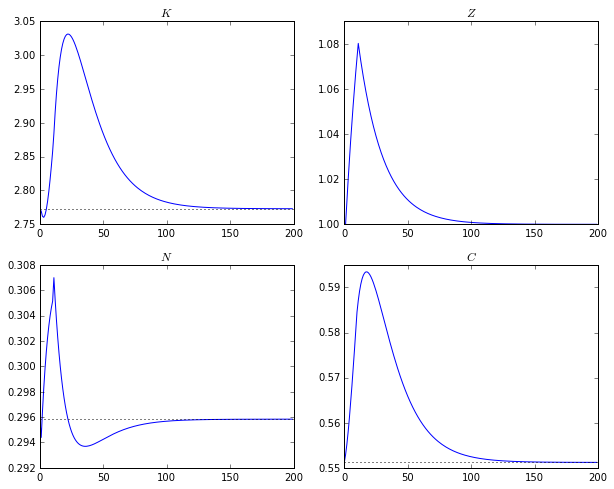

In [38]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,8)


ax[0, 0].set_title('$K$')
ax[0, 0].plot(kb + kb*x1[:, 0, :])
ax[0, 0].axhline(kb, color='black', linestyle='dotted')

ax[0, 1].set_title('$Z$')
ax[0, 1].plot(zb + zb*x1[:, 1, :])
ax[0, 1].axhline(zb, color='black', linestyle='dotted')

ax[1, 0].set_title('$N$')
ax[1, 0].plot(nb + nb*x2[:, 0, :])
ax[1, 0].axhline(nb, color='black', linestyle='dotted')

ax[1, 1].set_title('$C$')
ax[1, 1].plot(cb + cb*x2[:, 1, :])
ax[1, 1].axhline(cb, color='black', linestyle='dotted')

ここで作成したコードを汎用的なものにするには, 関数やクラスを作って上記の手続きを抽象化しておくとよい. 各自で試してほしい. 

#### 保存

使い回しのために係数行列を保存しておこう. 

In [39]:
np.savez('coeff', Omega_x=Omega_x, Omega_y=Omega_y, Omega_u=Omega_u,
         Psi_x=Psi_x, Psi_y=Psi_y, Tuu=T[_uu], Suu=S[_uu], Cu=C[_u])